## Imports and Notebook formating

In [1]:
from __future__ import print_function

import sys
import pyodbc
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#make the layout full width
from IPython.display import clear_output
from IPython.core.display import display, HTML
'''
display(HTML("<style>.container { width:100% !important; }</style>"))

#prevent widget cells from going to scoll
style = """
    <style>
       .jupyter-widgets-output-area .output_scroll {
            height: unset !important;
            border-radius: unset !important;
            -webkit-box-shadow: unset !important;
            box-shadow: unset !important;
        }
        .jupyter-widgets-output-area  {
            height: auto !important;
        }
    </style>
    """
display(HTML(style))
'''
connectionString = 'Driver={SQL Server};Server=tcp:nemdatasvr.database.windows.net;Database=MMSDM;Uid=MMSDM_ReadOnly;Pwd=5!46E~MExF;'

# NEM data table exploration
Data will be loaded for a random day, and the data relationships between key tables will be examined

In [2]:
randomDay = '2020220'
randomDayEndTime = '20200221'
randomRegion = 'NSW1'

## Demand

In [3]:
demandSql = "select distinct * from DISPATCHREGIONSUM where SETTLEMENTDATE > '" + randomDay + "' and SETTLEMENTDATE <= '" \
    + randomDayEndTime + "' and INTERVENTION =1"
cnxn = pyodbc.connect(connectionString)
demand = pd.read_sql(demandSql,cnxn)
demand.head()

,SETTLEMENTDATE,RUNNO,REGIONID,DISPATCHINTERVAL,INTERVENTION,TOTALDEMAND,AVAILABLEGENERATION,AVAILABLELOAD,DEMANDFORECAST,DISPATCHABLEGENERATION,...,DEMAND_AND_NONSCHEDGEN,UIGF,SEMISCHEDULE_CLEAREDMW,SEMISCHEDULE_COMPLIANCEMW,SS_SOLAR_UIGF,SS_WIND_UIGF,SS_SOLAR_CLEAREDMW,SS_WIND_CLEAREDMW,SS_SOLAR_COMPLIANCEMW,SS_WIND_COMPLIANCEMW


From the MMS Data Model (https://www.aemo.com.au/-/media/Files/Electricity/NEM/IT-Systems-and-Change/MMS-Data-Model-Report.pdf)

**TOTALDEMAND** Demand (less loads)

**AVAILABLEGENERATION** Aggregate generation bid available in region

**AVAILABLELOAD** Aggregate load bid available in region

**DISPATCHABLEGENERATION** Dispatched Generation



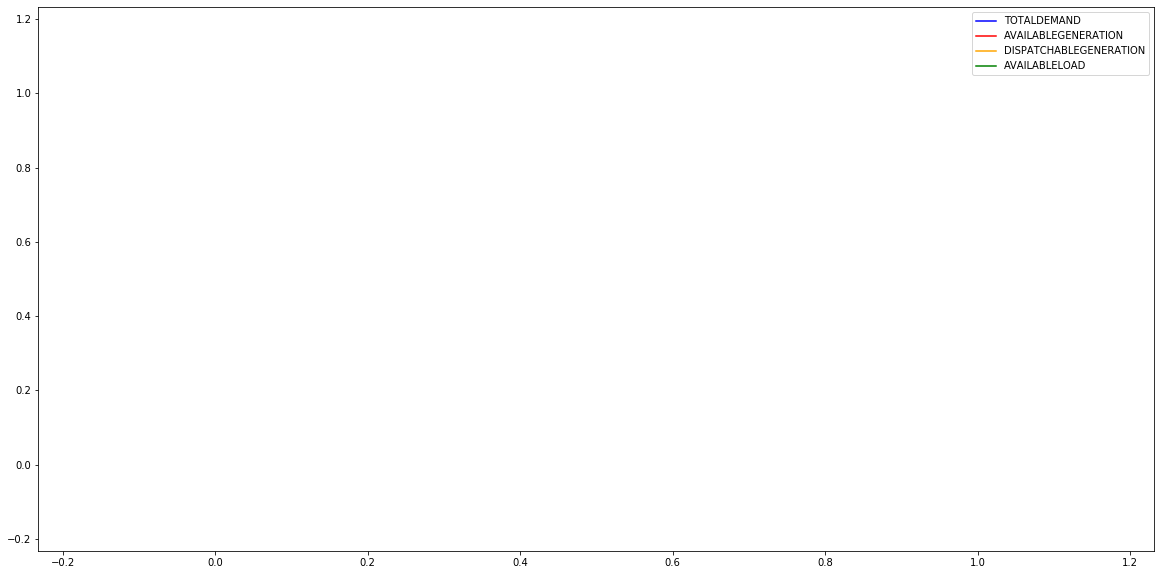

In [4]:
regionDemand = demand[demand.REGIONID == randomRegion]

plt.figure(figsize=(20,10))
plt.plot('SETTLEMENTDATE', 'TOTALDEMAND', data=regionDemand, color='blue')
plt.plot('SETTLEMENTDATE', 'AVAILABLEGENERATION', data=regionDemand, color='red')
plt.plot('SETTLEMENTDATE', 'DISPATCHABLEGENERATION', data=regionDemand, color='orange')
plt.plot('SETTLEMENTDATE', 'AVAILABLELOAD', data=regionDemand, color='green')
plt.legend()

## Generation and Transmission

In [5]:
generationByDuidSql = '''
select distinct * from (
    select dus.*
    from [dbo].[DISPATCH_UNIT_SCADA] dus 
    inner join DUDETAILSUMMARY dds on dds.DUID = dus.DUID
    where dus.SETTLEMENTDATE > '{0}' and dus.SETTLEMENTDATE <= '{1}' and dds.REGIONID = '{2}'
) x
'''.format(randomDay, randomDayEndTime, randomRegion)
cnxn = pyodbc.connect(connectionString)
generationByDuid = pd.read_sql(generationByDuidSql,cnxn)
generationByDuid.sort_values(by='SETTLEMENTDATE').reset_index(drop=True, inplace=True)
generationByDuid.head()

,SETTLEMENTDATE,DUID,SCADAVALUE
0,2020-02-20 00:05:00,BERYLSF1,-0.19032
1,2020-02-20 00:05:00,BLOWERNG,5.10000
2,2020-02-20 00:05:00,BOCORWF1,76.45000
3,2020-02-20 00:05:00,BODWF1,13.96236
4,2020-02-20 00:05:00,BROKENH1,0.00000


In [6]:
allDuidsInRegion = generationByDuid.DUID.unique()
allDuidsInRegion

array(['BERYLSF1', 'BLOWERNG', 'BOCORWF1', 'BODWF1', 'BROKENH1', 'BW01',
       'BW02', 'BW03', 'BW04', 'CAPTL_WF', 'CG1', 'CG2', 'CG3', 'CG4',
       'COLEASF1', 'CROOKWF2', 'CULLRGWF', 'DG_NSW1', 'ER01', 'ER02',
       'ER03', 'ER04', 'ERGT01', 'FINLYSF1', 'GB01', 'GRIFSF1',
       'GULLRSF1', 'GULLRWF1', 'GUNNING1', 'GUTHEGA', 'HUMENSW', 'HVGTS',
       'LD01', 'LD02', 'LD03', 'LD04', 'LIMOSF21', 'MANSLR1', 'MLSP1',
       'MOREESF1', 'MP1', 'MP2', 'NEVERSF1', 'NYNGAN1', 'PARSF1',
       'ROYALLA1', 'RT_NSW1', 'RT_NSW2', 'RT_NSW3', 'RT_NSW4', 'RT_NSW5',
       'RT_NSW6', 'SAPHWF1', 'SHGEN', 'SHPUMP', 'SITHE01', 'SNOWYP',
       'STWF1', 'TALWA1', 'TARALGA1', 'TUMUT3', 'UPPTUMUT', 'URANQ11',
       'URANQ12', 'URANQ13', 'URANQ14', 'VP5', 'VP6', 'WOODLWN1', 'WRSF1',
       'WRWF1'], dtype=object)

In [7]:
duidsSortedByTotalGen = generationByDuid.groupby("DUID")["SCADAVALUE"].sum().sort_values(ascending=False).index

Stacked generation for biggest generators in region

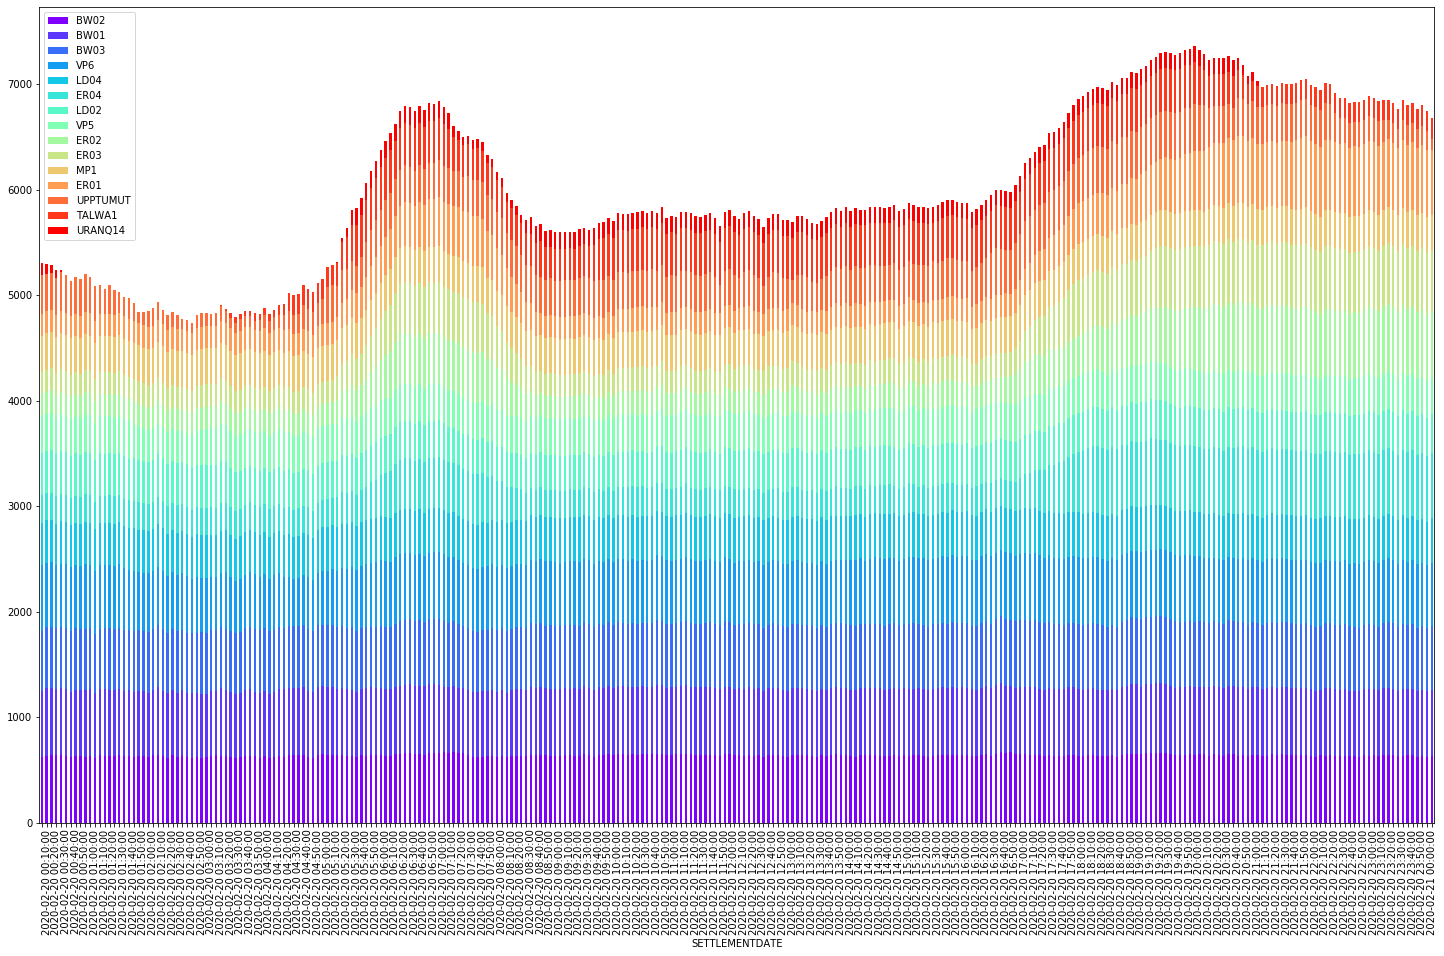

In [8]:
import matplotlib.cm as cm

biggestGen = generationByDuid.groupby("DUID")["SCADAVALUE"].sum().sort_values(ascending=False).head(15).index
colors = cm.rainbow(np.linspace(0, 1, len(biggestGen)))

fig, ax = plt.subplots(figsize=(25,15))  
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

bottom = np.zeros(len(generationByDuid.SETTLEMENTDATE.unique()))
for num, duid in enumerate(biggestGen):
    duidData = generationByDuid[generationByDuid.DUID == duid].copy()
    duidData.plot.bar(x='SETTLEMENTDATE',y='SCADAVALUE', stacked=True, ax=ax, color=colors[num],
                                    bottom = bottom, label=duid)
    bottom = bottom + np.array(duidData.SCADAVALUE)

for label in ax.get_xaxis().get_ticklabels()[::2]:
    label.set_visible(False)
    
plt.show()

Demand vs generation in the region

TypeError: no numeric data to plot

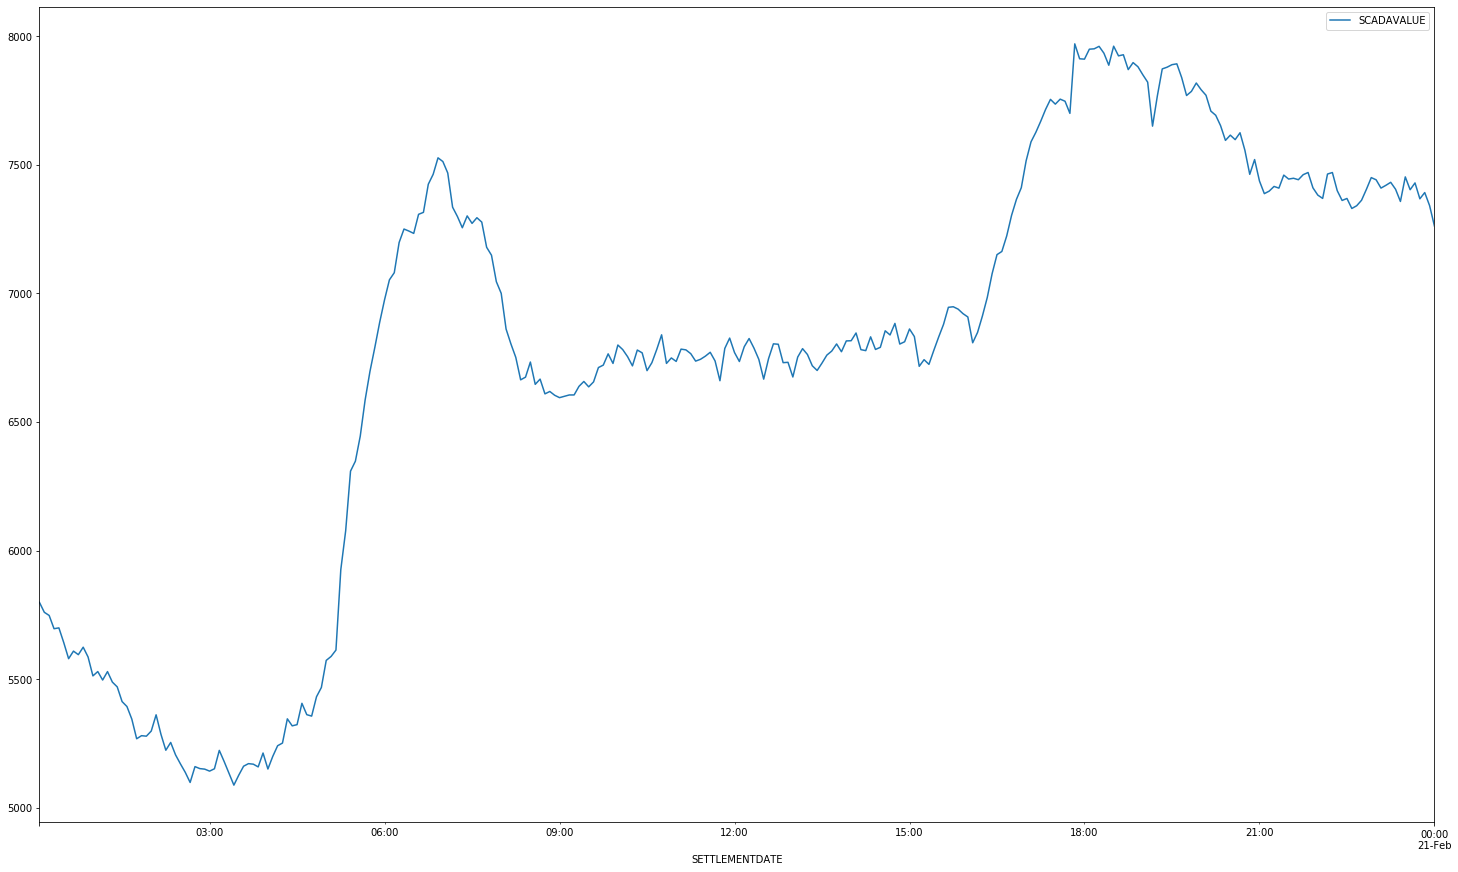

In [9]:
totalRegionGeneration = generationByDuid.groupby("SETTLEMENTDATE")["SCADAVALUE"].sum().reset_index()

fig, ax = plt.subplots(figsize=(25,15))  
totalRegionGeneration.plot(x='SETTLEMENTDATE',y='SCADAVALUE', ax=ax)
regionDemand.plot(x='SETTLEMENTDATE', y='TOTALDEMAND', ax=ax)

plt.show()

## Interconenctors

The data is metered energy (MWh) not power flow (MW), and is only updated weekly.  Doesn't look very valuable

In [10]:
regionInterconnectsSql = '''
select intf.*
from [INTERCONNECTOR] intid
inner join INTERCONNMWFLOW intf on  intf.INTERCONNECTORID = intid.[INTERCONNECTORID] 
where ([REGIONFROM] = '{0}' or [REGIONTO] = '{0}')
and intf.SETTLEMENTDATE > '{1}' and intf.SETTLEMENTDATE <= '{2}'
'''.format(randomRegion, randomDay, randomDayEndTime)
cnxn = pyodbc.connect(connectionString)
regionInterconnects = pd.read_sql(regionInterconnectsSql,cnxn)
regionInterconnects

,SETTLEMENTDATE,VERSIONNO,INTERCONNECTORID,PERIODID,IMPORTENERGYVALUE,EXPORTENERGYVALUE,LASTCHANGED
0,2020-02-21,7677.0,N-Q-MNSP1,1.0,0.211966,0.000000,2020-02-23 23:55:10
1,2020-02-21,7677.0,N-Q-MNSP1,2.0,0.000000,4.805615,2020-02-23 23:55:10
2,2020-02-21,7677.0,N-Q-MNSP1,3.0,0.000000,13.690827,2020-02-23 23:55:10
3,2020-02-21,7677.0,N-Q-MNSP1,4.0,0.000000,10.514323,2020-02-23 23:55:10
4,2020-02-21,7677.0,N-Q-MNSP1,5.0,0.000000,15.000152,2020-02-23 23:55:10
...,...,...,...,...,...,...,...
1291,2020-02-21,7888.0,VIC1-NSW1,44.0,0.000000,113.438535,2020-07-02 01:49:10
1292,2020-02-21,7888.0,VIC1-NSW1,45.0,0.000000,208.325406,2020-07-02 01:49:10
1293,2020-02-21,7888.0,VIC1-NSW1,46.0,0.000000,232.108398,2020-07-02 01:49:10
1294,2020-02-21,7888.0,VIC1-NSW1,47.0,0.000000,120.405172,2020-07-02 01:49:10


## Price Data

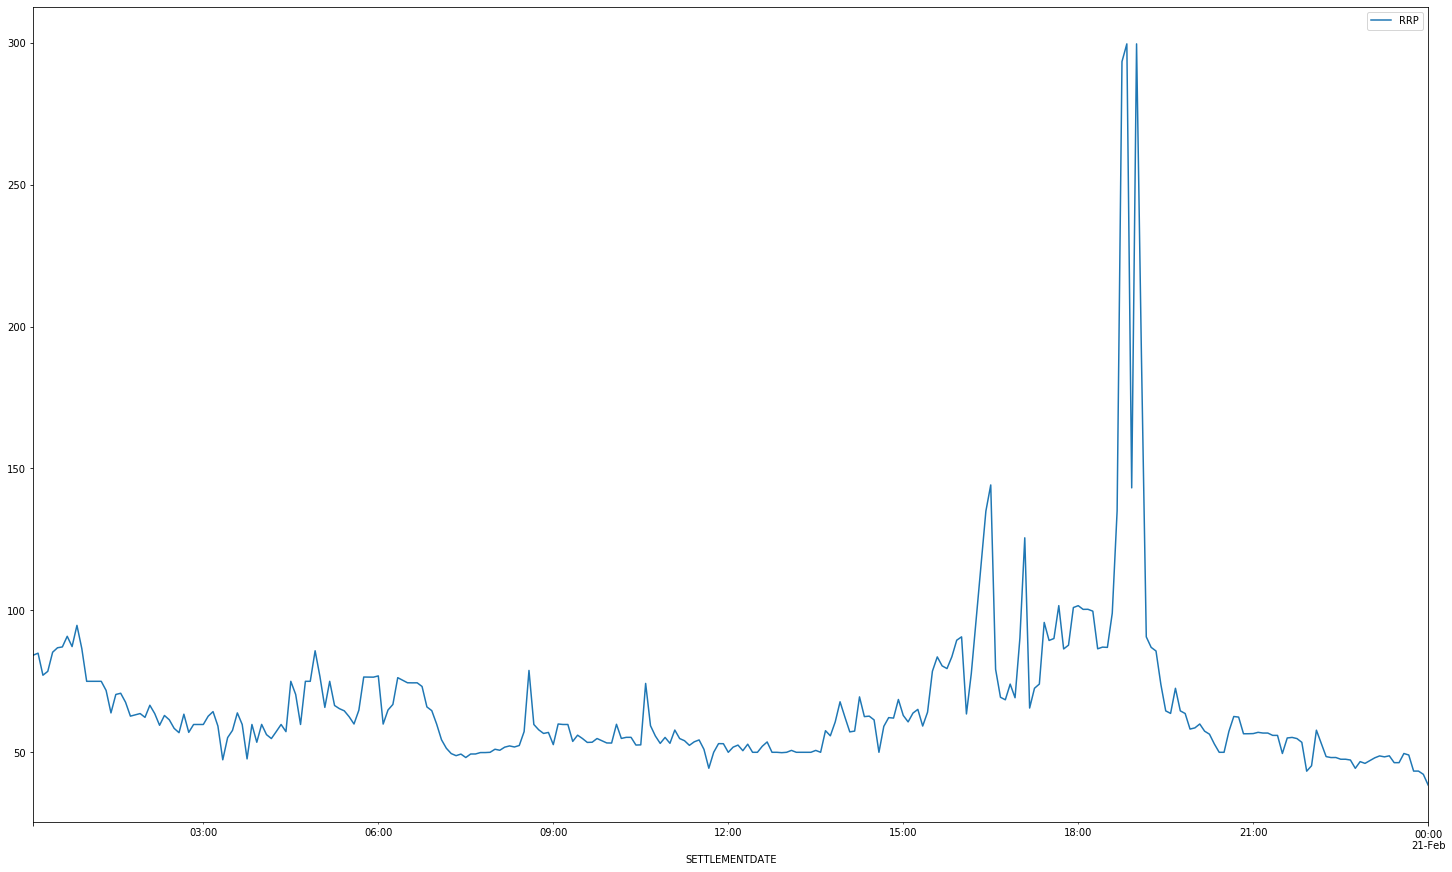

In [11]:
tradingPriceSql = '''
SELECT [SETTLEMENTDATE]  ,[RRP] FROM [dbo].[DISPATCHPRICE]
WHERE  [REGIONID] = '{0}'
and SETTLEMENTDATE > '{1}' and SETTLEMENTDATE <= '{2}' and INTERVENTION = 0
'''.format(randomRegion, randomDay, randomDayEndTime)
cnxn = pyodbc.connect(connectionString)
tradingPrice = pd.read_sql(tradingPriceSql,cnxn)

fig, ax = plt.subplots(figsize=(25,15))  
tradingPrice.plot(x='SETTLEMENTDATE',y='RRP', ax=ax)

In [12]:
tradingPriceSql.replace('\n', ' ')

" SELECT [SETTLEMENTDATE]  ,[RRP] FROM [dbo].[DISPATCHPRICE] WHERE  [REGIONID] = 'NSW1' and SETTLEMENTDATE > '20 Feb 2020' and SETTLEMENTDATE <= '21 Feb 2020' and INTERVENTION = 0 "

Manually calculate the settlement price.  Shift time to start of period

In [13]:
tradingPrice.SETTLEMENTDATE = tradingPrice.SETTLEMENTDATE - dt.timedelta(minutes=5)

In [14]:
settlementPriceCalculated = tradingPrice.set_index('SETTLEMENTDATE').resample('30T').mean().reset_index()
settlementPriceCalculated.SETTLEMENTDATE = settlementPriceCalculated.SETTLEMENTDATE + dt.timedelta(minutes=30)
settlementPriceCalculated = settlementPriceCalculated.round(2)
settlementPriceCalculated.head(10)

,SETTLEMENTDATE,RRP
0,2020-02-20 00:30:00,82.82
1,2020-02-20 01:00:00,86.92
2,2020-02-20 01:30:00,71.85
3,2020-02-20 02:00:00,65.05
4,2020-02-20 02:30:00,62.10
5,2020-02-20 03:00:00,59.46
6,2020-02-20 03:30:00,57.76
7,2020-02-20 04:00:00,57.42
8,2020-02-20 04:30:00,60.07
9,2020-02-20 05:00:00,73.76


Compare with AEMO settlement price

In [15]:
settlementPriceSql = '''
SELECT [SETTLEMENTDATE]  ,[RRP] FROM [dbo].[TRADINGPRICE]
WHERE  [REGIONID] = '{0}'
and SETTLEMENTDATE > '{1}' and SETTLEMENTDATE <'{2}'
'''.format(randomRegion, randomDay, randomDayEndTime)
cnxn = pyodbc.connect(connectionString)
settlementPrice = pd.read_sql(settlementPriceSql,cnxn)
settlementPrice.head(10)

,SETTLEMENTDATE,RRP
0,2020-02-20 00:30:00,82.82
1,2020-02-20 01:00:00,86.92
2,2020-02-20 01:30:00,71.85
3,2020-02-20 02:00:00,65.05
4,2020-02-20 02:30:00,62.10
5,2020-02-20 03:00:00,59.46
6,2020-02-20 03:30:00,57.76
7,2020-02-20 04:00:00,57.42
8,2020-02-20 04:30:00,60.07
9,2020-02-20 05:00:00,73.76


## Offline DUIDS

In [16]:
pdpasaSql = '''
select run_datetime, interval_datetime, regionid, aggregatecapacityavailable as MaxAvail, 
AGGREGATEPASAAVAILABILITY as STPASA
--,aggregatescheduledload, totalintermittentgeneration + uigf renewables
from PDPASA_REGIONSOLUTION
where run_datetime = '{0}'
'''.format(randomDay)
cnxn = pyodbc.connect(connectionString)
pdpasa = pd.read_sql(pdpasaSql,cnxn)
pdpasa.head(10)

,run_datetime,interval_datetime,regionid,MaxAvail,STPASA
0,2020-02-20,2020-02-20 00:00:00,NSW1,8216.0,9856.0
1,2020-02-20,2020-02-20 00:00:00,QLD1,10569.0,10899.0
2,2020-02-20,2020-02-20 00:00:00,SA1,2240.0,3072.0
3,2020-02-20,2020-02-20 00:00:00,TAS1,1970.0,2114.0
4,2020-02-20,2020-02-20 00:00:00,VIC1,7835.0,8679.0
5,2020-02-20,2020-02-20 00:30:00,NSW1,8050.0,9856.0
6,2020-02-20,2020-02-20 00:30:00,QLD1,10425.0,10915.0
7,2020-02-20,2020-02-20 00:30:00,SA1,2240.0,3072.0
8,2020-02-20,2020-02-20 00:30:00,TAS1,1970.0,2114.0
9,2020-02-20,2020-02-20 00:30:00,VIC1,7835.0,8679.0


In [17]:
pdpasa.run_datetime.unique()

array(['2020-02-20T00:00:00.000000000'], dtype='datetime64[ns]')

In [30]:

stPasaSql = '''
select run_datetime, interval_datetime, regionid, aggregatecapacityavailable as MaxAvail, AGGREGATEPASAAVAILABILITY as STPASA
 --,aggregatescheduledload, totalintermittentgeneration + uigf renewables
from stpasa_regionsolution
where run_datetime = '{}'
'''.format(randomDay)
cnxn = pyodbc.connect(connectionString)
stPasa = pd.read_sql(stPasaSql,cnxn)
stPasa.head(10)

,run_datetime,interval_datetime,regionid,MaxAvail,STPASA
0,2020-02-20,2020-02-21 04:30:00,NSW1,10708.0,12093.0
1,2020-02-20,2020-02-21 04:30:00,QLD1,10381.0,11359.0
2,2020-02-20,2020-02-21 04:30:00,SA1,2134.0,3038.0
3,2020-02-20,2020-02-21 04:30:00,TAS1,2026.0,2114.0
4,2020-02-20,2020-02-21 04:30:00,VIC1,7957.0,8679.0
5,2020-02-20,2020-02-21 05:00:00,NSW1,10708.0,12093.0
6,2020-02-20,2020-02-21 05:00:00,QLD1,10381.0,11359.0
7,2020-02-20,2020-02-21 05:00:00,SA1,2135.0,3039.0
8,2020-02-20,2020-02-21 05:00:00,TAS1,2026.0,2114.0
9,2020-02-20,2020-02-21 05:00:00,VIC1,7957.0,8679.0


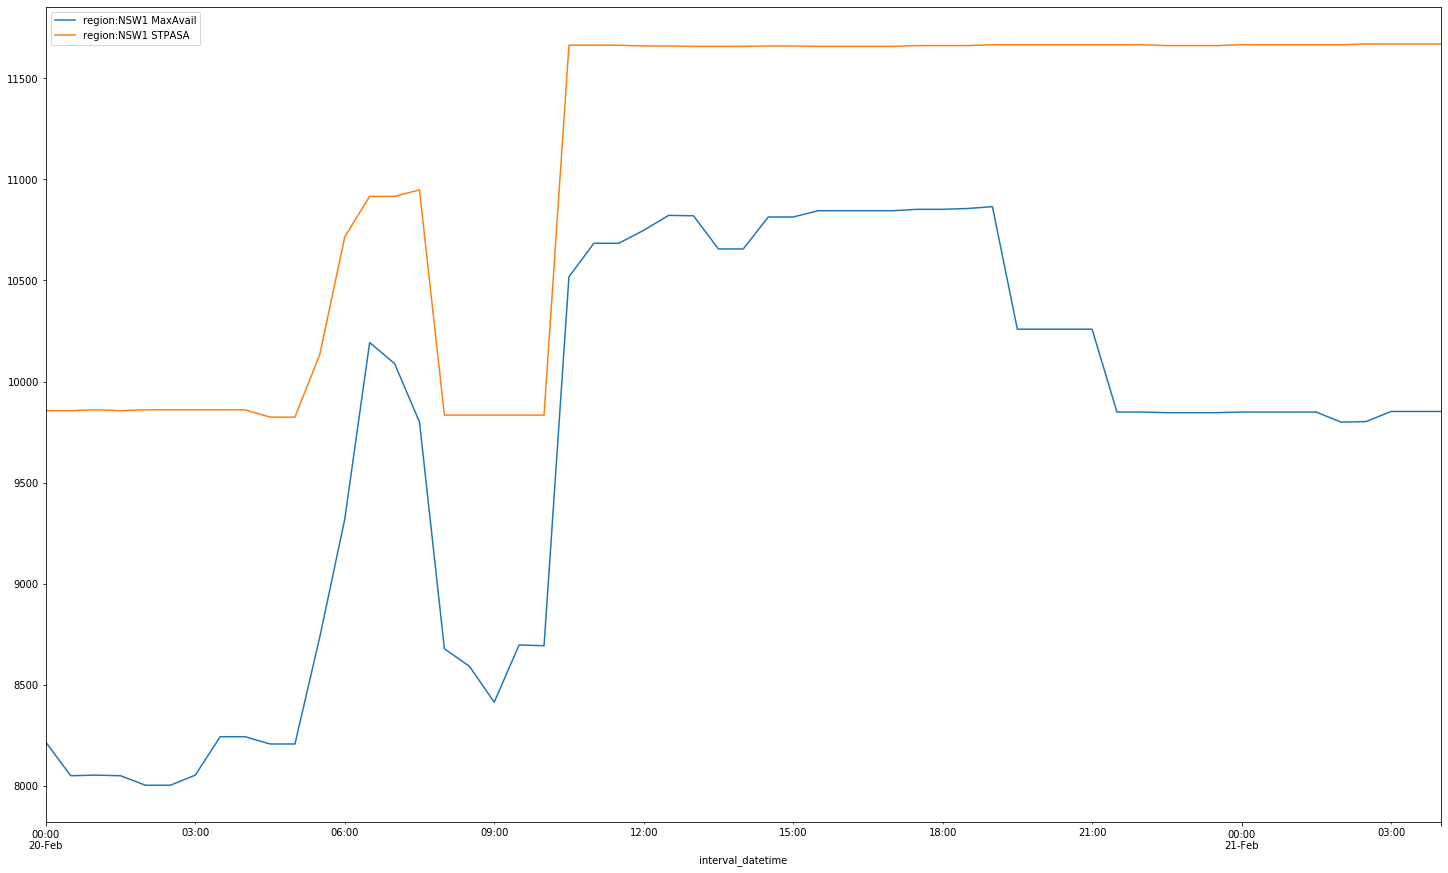

In [31]:
fig, ax = plt.subplots(figsize=(25,15))  
#ax.set_ylim([10000,13000])
for region in ['NSW1']:
    pdpasa[pdpasa.regionid == region].plot(x='interval_datetime',y='MaxAvail', ax=ax, label= 'region:' + region + ' MaxAvail')
    pdpasa[pdpasa.regionid == region].plot(x='interval_datetime', y='STPASA', ax=ax, label= 'region:' + region + ' STPASA')
plt.show()


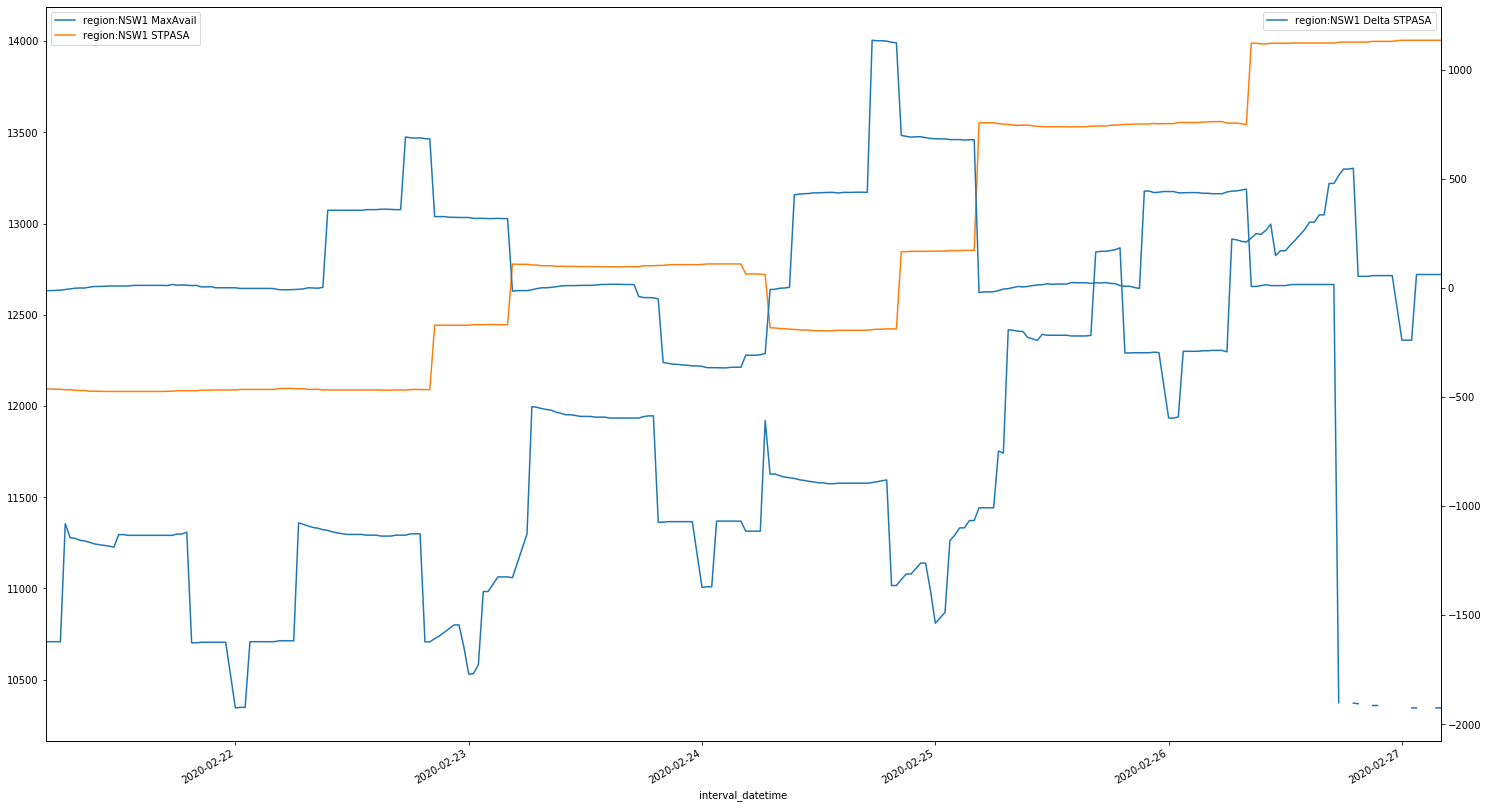

In [45]:
fig, ax = plt.subplots(figsize=(25,15))  
ax2 = ax.twinx()
#ax.set_ylim([8000,15000])

state = stPasa[stPasa.regionid == 'NSW1'].copy()
state['Delta_STPASA'] = state['STPASA'].shift(-22) - state['STPASA']
state['Delta_MaxAvail'] = state['MaxAvail'].shift(-48) -state['MaxAvail']

state.plot(x='interval_datetime',y='MaxAvail', ax=ax, label= 'region:' + region + ' MaxAvail')
state.plot(x='interval_datetime', y='STPASA', ax=ax, label= 'region:' + region + ' STPASA')
state.plot(x='interval_datetime', y='Delta_STPASA', ax=ax2, label= 'region:' + region + ' Delta STPASA')
#qld.plot(x='interval_datetime', y='Delta_MaxAvail', ax=ax2, label= 'region:' + region + ' Delta MaxAvail')

plt.show()

In [55]:
state[state.interval_datetime > dt.datetime(2020, 1, 25)] [['interval_datetime','STPASA', 'Delta_STPASA']].head(60)

,interval_datetime,STPASA,Delta_STPASA
0,2020-02-21 04:30:00,12093.0,-13.0
5,2020-02-21 05:00:00,12093.0,-13.0
10,2020-02-21 05:30:00,12092.0,-12.0
15,2020-02-21 06:00:00,12092.0,-11.0
20,2020-02-21 06:30:00,12089.0,-8.0
25,2020-02-21 07:00:00,12089.0,-5.0
30,2020-02-21 07:30:00,12086.0,-2.0
35,2020-02-21 08:00:00,12085.0,-1.0
40,2020-02-21 08:30:00,12085.0,-1.0
45,2020-02-21 09:00:00,12081.0,3.0


In [34]:
state.Delta_STPASA.unique()

array([-1.200e+01, -9.000e+00, -6.000e+00, -5.000e+00, -1.000e+00,
        0.000e+00,  1.000e+00,  4.000e+00,  7.000e+00,  3.000e+00,
        8.000e+00,  6.000e+00,  5.000e+00, -3.000e+00, -8.000e+00,
       -7.000e+00, -4.000e+00,  2.000e+00,  3.560e+02,  3.550e+02,
        3.530e+02,  3.520e+02,  3.350e+02,  3.340e+02,  3.310e+02,
        3.270e+02,  3.260e+02,  3.220e+02,  3.230e+02,  3.200e+02,
       -2.000e+00,  1.100e+01, -5.100e+01, -5.200e+01, -5.500e+01,
       -5.600e+01, -5.900e+01, -3.500e+02, -3.510e+02, -3.540e+02,
       -3.550e+02, -3.580e+02, -3.040e+02, -3.070e+02, -1.600e+01,
       -1.500e+01, -1.300e+01,  9.000e+00,  4.310e+02,  4.330e+02,
        4.320e+02,  4.290e+02,  4.270e+02,  4.280e+02,  4.260e+02,
        7.040e+02,  6.960e+02,  6.930e+02,  6.920e+02,  6.870e+02,
        6.850e+02, -1.700e+01, -2.000e+01, -2.100e+01, -1.400e+01,
       -1.000e+01,  1.300e+01,  1.500e+01,  1.200e+01,  1.400e+01,
        1.000e+01, -1.100e+01,  4.300e+02,  4.380e+02,  4.420e

declare @dt datetime = '14 Aug 2020 11:00:00'

select	X.settlementdate, x.DUID, x.regionid, x.initialMW,
		X.maxcapacity--, Price.rrp

from
(

	select	gen.settlementdate,
			gen.duid, lib.regionid, lib.Fuel_Type, lib.technology_type,
			gen.scadavalue initialMW, maxcapacity - scadavalue headroom, lib.maxcapacity

	from

	(
		select *
		from dispatch_unit_scada
		where	settlementdate in
					(	select distinct max(settlementdate)
						from  dispatch_unit_scada
						where settlementdate = @dt
					)
				and DUID not in ('RT_NSW1',	'RT_NSW2',	'RT_NSW3',	'RT_NSW4',	'RT_NSW5',	'RT_NSW6',	
								'RT_QLD1',	'RT_SA1',	'RT_SA2',	'RT_SA3',	'RT_SA4',	'RT_SA5',	'RT_SA6',	
								'RT_TAS1',	'RT_VIC1',	'RT_VIC10',	'RT_VIC11',	'RT_VIC12',	'RT_VIC2',	'RT_VIC3',	
								'RT_VIC4',	'RT_VIC5',	'RT_VIC6',	'RT_VIC7',	'RT_VIC8',	'RT_VIC9',
								'DG_VIC1', 'DG_TAS1', 'DG_NSW1', 'DG_SA1', 'DG_QLD1')
				and scadavalue <> 0
	) Gen

	left join

	(

		select settlementdate, duid, totalcleared, availability
			from dispatchload
			where	settlementdate in
						(	select distinct max(settlementdate)
							from  dispatch_unit_scada
							where settlementdate = @dt
						)
					and intervention = 0

	) Target on target.settlementdate = Gen.settlementdate and target.duid = gen.duid

	left join
	(
		select	dl.settlementdate, dl.duid, dlp.local_price_adjustment, 
				case 
					when semidispatchcap =1 or local_price_adjustment <> 0
						then 1
					when semidispatchcap =0
						then 0
				end constrained
		from
		(
			select settlementdate, duid, semidispatchcap
			from dispatchload
			where	settlementdate in
						(	select distinct max(settlementdate)
							from  dispatch_unit_scada
							where settlementdate = @dt
						)
		) dl
		left join
		(
			select *
			from dispatch_local_price
			where settlementdate in
						(	select distinct max(settlementdate)
							from  dispatch_unit_scada
							where settlementdate = @dt
						)
		) dlp on dl.settlementdate = dlp.settlementdate and dl.duid = dlp.duid

	) Ed_c on Ed_c.settlementdate = Gen.settlementdate and Ed_c.duid = Gen.duid

	inner join

	(

		select		b.REGIONID, c.NAME, d.STATIONNAME, a.DUID, 
					a.REGISTEREDCAPACITY, a.MAXCAPACITY, 
					b.TRANSMISSIONLOSSFACTOR, b.DISTRIBUTIONLOSSFACTOR,
					a.MAXRATEOFCHANGEUP, a.MAXRATEOFCHANGEDOWN,
					b.SCHEDULE_TYPE, b.dispatchtype,
					a.CONNECTIONPOINTID, VOLTLEVEL, a.STARTTYPE, IS_AGGREGATED,


					Fuel_type,

					case 
						when stationname in ('CALLIDE C NETT OFF', 'Kogan Creek Power Station', 
						'Millmerran Power Plant','Tarong North Power Station') 
							then 'Steam Super Critical'
						when Fuel_Type = 'Gas' and stationname not in ('Condamine Power Station A','Darling Downs Power Station',
						'OSBORNE POWER STATION','Pelican Point Power Station','Townsville Gas Turbine', 'Tamar Valley Combined Cycle Power Station', 
						'Tallawarra Power Station', 'Swanbank B Power Station & Swanbank E Gas Turbine', 'Yarwun Power Station', 'Townsville Gas Turbine',
						'Barker Inlet Power Station', 'TORRENS ISLAND POWER STATION', 'NEWPORT POWER STATION') or a.duid in ('POR01','POR03','SNUG1')
							then 'OCGT'
						when Fuel_Type = 'Gas' and stationname in ('Condamine Power Station A','Darling Downs Power Station',
						'OSBORNE POWER STATION','Pelican Point Power Station','Townsville Gas Turbine', 'Tamar Valley Combined Cycle Power Station', 
						'Tallawarra Power Station', 'Swanbank B Power Station & Swanbank E Gas Turbine', 'Yarwun Power Station', 'Townsville Gas Turbine')
							then 'CCGT'
						when Fuel_Type in ('Black Coal', 'Brown Coal', 'Gas') and stationname not in ('CALLIDE C NETT OFF', 'Kogan Creek Power Station', 
						'Millmerran Power Plant','Tarong North Power Station') or stationname in ('TORRENS ISLAND POWER STATION', 'NEWPORT POWER STATION')
							then 'Steam Sub Critical' 
						when stationname in ('ANGASTON POWER STATION','Lonsdale Power Station','Pt Stanvac Power Station','Barker Inlet Power Station')
							or a.DUID in ('SATGN1', 'SATGS1')
							then 'Reciprocating Engine'
						/*when Fuel_Type = 'Hydro' and a.duid in ('BLOWERNG', 'MURRAY', 'UPPTUMUT', 'GUTHEGA', ) or (Fuel_Type = 'Hydro' and 
							b.regionid = 'VIC1') 
							then 'Dam'
						when Fuel_Type = 'Hydro' and a.duid in ('TUMUT3', 'SNOWYP', 'SHGEN', 'SHPUMP', 
						'W/HOE#1', 'W/HOE#2', 'PUMP1', 'PUMP2')
							then 'Pumped Hydro'
						when Fuel_Type = 'Hydro' and a.duid in ('BLOWERNG', 'MURRAY', 'UPPTUMUT', 'GUTHEGA')
							then 'Run of the River'
						when a.duid = 'SNOWYGJP' then 'Pump'*/
					end technology_type



		from
		(
			select	DUID, CONNECTIONPOINTID, VOLTLEVEL, REGISTEREDCAPACITY, MAXCAPACITY, STARTTYPE,
					MAXRATEOFCHANGEUP, MAXRATEOFCHANGEDOWN,

					case
						when a.duid in ('BW01','BW02','BW03','BW04','ER01','ER02','ER03','ER04','ERGT01',
						'LD01','LD02','LD03','LD04','MM3','MM4','MP1','MP2','REDBANK1','VP5','VP6','WW7',
						'WW8','CALL_A_2','CALL_A_4','CALL_B_1','CALL_B_2','COLNSV_1','COLNSV_2','COLNSV_3',
						'COLNSV_4','COLNSV_5','CPP_3','CPP_4','GSTONE1','GSTONE2','GSTONE3','GSTONE4','GSTONE5',
						'GSTONE6','KPP_1','MPP_1','MPP_2','STAN-1','STAN-2','STAN-3','STAN-4','SWAN_B_1','SWAN_B_2',
						'SWAN_B_3','SWAN_B_4','TARONG#1','TARONG#2','TARONG#3','TARONG#4','TNPS1')
							then 'Black Coal'
						when a.duid in ('APS','HWPS1','HWPS2','HWPS3','HWPS4','HWPS5','HWPS6','HWPS7',
						'HWPS8','LOYYB1','LOYYB2','LYA1','LYA2','LYA3','LYA4','MOR1','MOR2','MOR3',
						'YWPS1','YWPS2','YWPS3','YWPS4','NPS1','NPS2','PLAYB-AG')
							then 'Brown Coal'
						when a.duid in ('BBTHREE1','BBTHREE2','BBTHREE3','TVCC201','TVPP104','AGLSOM',
						'BDL01','BDL02','JLA01','JLA02','JLA03','JLA04','JLB01','JLB02','JLB03','LAVNORTH',
						'LNGS1','LNGS2','MORTLK11','MORTLK12','NPS','VPGS','VPGS1','VPGS2','VPGS3','VPGS4',
						'VPGS5','VPGS6','CG1','CG2','CG3','CG4','HVGTS','SITHE01','TALWA1','URANQ11','URANQ12',
						'URANQ13','URANQ14','BARCALDN','BRAEMAR1','BRAEMAR2','BRAEMAR3','BRAEMAR5','BRAEMAR6',
						'BRAEMAR7','CPSA','DDPS1','OAKEY1','OAKEY2','ROMA_7','ROMA_8','SWAN_E',
						'YABULU','YABULU2','YARWUN_1','AGLHAL','BARKIPS1','DRYCGT1','DRYCGT2','DRYCGT3','LADBROK1',
						'LADBROK2','MINTARO','OSB-AG','PPCCGT','QPS1','QPS2','QPS3','QPS4','QPS5','TORRA1','TORRA2',
						'TORRA3','TORRA4','TORRB1','TORRB2','TORRB3','TORRB4')
							then 'Gas'
						when a.duid in ('ASNENC1','GB01','ANGAS1','ANGAS2','ANGAST1','ASSENC1','LONSDALE','POR01','POR03',
						'PTSTAN1','SATGN1','SATGS1','SNUG1')
							then 'Liquid fuel'
						when a.duid in ('BBDISEL1','CATAGUN1','GEORGTN1','GEORGTN2','MEADOWB2', 'GERMCRK','MBAHNTH',
						'PORTLAT1','QUERIVE1', 'VENUS1','ASQENC1','MACKAYGT','MSTUART1','MSTUART2','MSTUART3')
							then 'Waste Gas'
						when a.duid in ('ASTHYD1', 'BASTYAN', 'BUTLERSG', 'CETHANA', 'CLUNY', 
						'DEVILS_G','FISHER','GORDON','JBUTTERS','LEM_WIL','LI_WY_CA','LK_ECHO',
						'MACKNTSH','MEADOWBK','PALOONA','POAT110','POAT220','REECE1','REECE2',
						'REPULSE','ROWALLAN','TARRALEA','TREVALLN','TRIBUTE','TUNGATIN', 'BLOWERNG',
						'BURRIN','GUTHEGA','HUMENSW','JNDABNE1','SHGEN', 'TUMUT3',
						'TUMUT3-1','TUMUT3-2','TUMUT3-3','TUMUT3-4','TUMUT3-5','TUMUT3-6','UPPTUMUT','WG01',
						'INVICTA','PIONEER','RPCG','VICMILL1','CLOVER','DARTM1','EILDON1','EILDON2',
						'HUMEV','MCKAY1','MURRAY','RUBICON','WKIEWA1','WKIEWA2','BARRON-1',
						'BARRON-2','KAREEYA1','KAREEYA2','KAREEYA3','KAREEYA4','W/HOE#1','W/HOE#2')
							then 'Hydro Gen'
						when a.duid in ('SNOWYP', 'SNOWYGJP', 'SHPUMP', 'PUMP1', 'PUMP2')
							then 'Hydro Pump'
						when a.duid in ('BALBG1','GANNBG1','DALNTH01','HPRG1','LBBG1')
							then 'Battery Discharge'
						when a.duid in ('BALBL1','GANNBL1','DALNTHL1','HPRL1','LBBL1')
							then 'Battery Charge'
						when a.duid in ('CTHLWF1','GRANWF1','MUSSELR1','WOOLNTH1','ARWF1','BALDHWF1','BULGANA1',
						'CHALLHWF','CHYTWF1','CROWLWF1','DUNDWF1','DUNDWF2','DUNDWF3','ELAINWF1','KIATAWF1',
						'MACARTH1','MERCER01','MLWF1','MTGELWF1','MUWAWF1','OAKLAND1','PORTWF','SALTCRK1','WAUBRAWF',
						'YAMBUKWF','YENDWF1','YSWF1','BOCORWF1','BODWF1','CAPTL_WF','CROOKWF2','CULLRGWF','GULLRWF1',
						'GULLRWF2','GUNNING1','SAPHWF1','STWF1','TARALGA1','WOODLWN1','WRWF1',
						'BLUFF1','CATHROCK','CLEMGPWF','CNUNDAWF','HALLWF1','HALLWF2','HDWF1','HDWF2','HDWF3','LGAPWF1','LKBONNY1',
						'LKBONNY2','LKBONNY3','MTMILLAR','NBHWF1','SNOWNTH1','SNOWSTH1','SNOWTWN1','STARHLWF','WATERLWF','WGWF1','WPWF')
							then 'Wind'
						when a.duid in ('BANN1','GANNSF1','KARSF1','NUMURSF1','WEMENSF1','BERYLSF1','BOMENSF1','BROKENH1',
						'COLEASF1','FINLYSF1','GOONSF1','GRIFSF1','GULLRSF1','LIMOSF11','LIMOSF21','MANSLR1','MLSP1','MOREESF1',
						'NASF1','NEVERSF1','NYNGAN1','PARSF1','ROYALLA1','SKSF1','WRSF1','COOPGWF1','MEWF1','BNGSF1','BNGSF2','TBSF1',
						'BARCSF1','CHILDSF1','CLARESF1','CLERMSF1',
						'CSPVPS1','DAYDSF1','DDSF1','EMERASF1','HAMISF1','HAUGHT11','HAYMSF1','HUGSF1','KSP1','LILYSF1',
						'LRSF1','MARYRSF1','OAKEY1SF','OAKEY2SF','RRSF1','RUGBYR1','SMCSF1','SRSF1','WHITSF1','YARANSF1',
						'ASSEL1','VSSAE1V1','VSSEL1V1', 'BAKING1', 'DARLSF1', 'KIAMSF1')
							then 'Solar'
						when a.duid in ('APD01', 'ASNACTW1','ASNAES1')
							then 'Other'
					end Fuel_Type
			from
			(
				Select	DUID, CONNECTIONPOINTID, VOLTLEVEL, REGISTEREDCAPACITY, MAXCAPACITY, STARTTYPE,
						MAXRATEOFCHANGEUP, MAXRATEOFCHANGEDOWN,
						EFFECTIVEDATE, VERSIONNO, MAX(effectivedate) over(partition by duid) mxED,
						MAX(versionno) over(partition by duid, effectivedate) mxVrsn
				from	dudetail du
				where	DUID in (
									select distinct duid 
									from DISPATCH_UNIT_SCADA 
									where	SETTLEMENTDATE = (select max(SETTLEMENTDATE) from DISPATCH_UNIT_SCADA)
											and DUID not in ('RT_NSW1',	'RT_NSW2',	'RT_NSW3',	'RT_NSW4',	'RT_NSW5',	'RT_NSW6',	
											'RT_QLD1',	'RT_SA1',	'RT_SA2',	'RT_SA3',	'RT_SA4',	'RT_SA5',	'RT_SA6',	
											'RT_TAS1',	'RT_VIC1',	'RT_VIC10',	'RT_VIC11',	'RT_VIC12',	'RT_VIC2',	'RT_VIC3',	
											'RT_VIC4',	'RT_VIC5',	'RT_VIC6',	'RT_VIC7',	'RT_VIC8',	'RT_VIC9',
											'DG_VIC1', 'DG_TAS1', 'DG_NSW1', 'DG_SA1', 'DG_QLD1')

								)
						

			) a
				where	EFFECTIVEDATE = mxED
				and VERSIONNO = mxVrsn
		) a inner join 

		(
			select	duid, DISPATCHTYPE, REGIONID, STATIONID, 
					PARTICIPANTID, TRANSMISSIONLOSSFACTOR, DISTRIBUTIONLOSSFACTOR,
					SCHEDULE_TYPE, IS_AGGREGATED

			from
			(

				select	duid, DISPATCHTYPE, REGIONID, STATIONID, 
						PARTICIPANTID, TRANSMISSIONLOSSFACTOR, DISTRIBUTIONLOSSFACTOR,
						SCHEDULE_TYPE, IS_AGGREGATED,
						START_DATE, END_DATE, LASTCHANGED, 
						MAX(END_DATE) over(partition by duid) mxEnd, 
						MAX(lastchanged) over(partition by duid) mxLastChanged

				from	DUDETAILSUMMARY

				where	duid in (
									select distinct duid 
									from DISPATCH_UNIT_SCADA 
									where SETTLEMENTDATE = (select max(SETTLEMENTDATE) from DISPATCH_UNIT_SCADA)
								)
			) b
			where	END_DATE = mxEnd
					and LASTCHANGED = mxLastChanged

		) b on a.DUID = b.DUID

		inner join 
		(
			select *
			from PARTICIPANT
		) c on b.PARTICIPANTID = c.participantid

		inner join
		(
			select *
			from STATION
		) d on b.stationid = d.stationid

	) Lib on Gen.duid = lib.duid
) X

left join
(
	select settlementdate, regionid, rrp
	from dispatchprice
	where	settlementdate in
				(	select distinct max(settlementdate)
					from  dispatch_unit_scada
					where settlementdate = @dt
				)
			and intervention = 0
) Price on X.regionid = Price.regionid

where Fuel_Type in ('Black Coal', 'Brown Coal')
				or technology_type = 'CCGT'

order by regionid, maxcapacity desc, Fuel_Type

select * from DISPATCH_UNIT_SCADA where SETTLEMENTDATE > '14 Aug 2020' and DUID = 'VP5' order by 1